In [1]:
import cProfile
import os
import statistics as st
import plotly.graph_objects as go
import random as rd
import time
import pandas as pd
import math
from collections import defaultdict
import numpy as np
import itertools as it
import Utilities.experiment_utils as eu
import unit_test as ut
import Games.mnk as mnk
import Games.Carcassonne.Carcassonne as carc
import Games.carcassonne_oldtry as csn_old
#import Games.carcassonne_older as csn
import Agents.random as arand
import Agents.vanilla_mcts as mcts
import Agents.siea_mcts as siea_mcts
import Agents.mcts_rave as rave_mcts
import Agents.one_step_lookahead as osla
import Agents.mcts_solver as mcts_solver
import Games.function_optimisation as fo
import Utilities.logs_management as lm
import Games.chess_64 as chess_64
import chess as chess
import chess.svg
import matplotlib.pyplot as plt
import shutil
import itertools
from IPython.display import display
import ast
from IPython.display import Image
import datetime
import multiprocessing as mp

#cProfile.run("wins =  random_games(10000, base_gs)")
#ut.run()

import scipy.stats

def t(alpha, gl):
    return scipy.stats.t.ppf(1-(alpha/2), gl)
#https://stackoverflow.com/questions/67340028/how-to-use-t-ppf-which-are-the-arguments
#https://stackoverflow.com/questions/40294844/calculate-t-student-test-for-the-next-table-in-python
#https://www.geeksforgeeks.org/python-students-t-distribution-in-statistics/
#https://itl.nist.gov/div898/handbook/eda/section3/eda352.htm
#https://docs.tibco.com/data-science/GUID-8E64444A-5F5B-49F9-A43A-74B13647AFB4.html#:~:text=The%20larger%20the%20variation%2C%20the%20less%20reliable%20the,sample%20size%20is%20large%2C%20say%20n%3D100%20or%20more.

In [2]:
#game_state = mnk.GameState(3,3,3)
game_state = carc.CarcassonneState(set_tile_sequence=True, set_tile_sequence_seed=0, players = 1, initial_meeples=[1,1])
game_state.set_initial_state()
agent = mcts.MCTS_Player(max_iterations = 50, logs = True, logs_every_iterations=10)
gp = eu.GamePlayer(game_state, [agent])
gp.play_game(random_seed=0)
gp.save_data(file_path = os.path.join("Outputs", "test", "gp_iteration_logs"))
#action = agent.choose_action(game_state)
#agent.dump_my_logs(path = os.path.join("Outputs", "test", "new_iteration_logs"))

In [2]:
##Multiprocess experiment
datetime_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_path = os.path.join("Outputs","Carcassonne_1p", datetime_string)

class ExperimentParser():
    def __init__(self, seed, games, runs, iterations, c, meeples, rollouts, random_events, file_path):
        self.seed = seed
        self.games = games
        self.runs = runs
        self.iterations = iterations
        self.c = c
        self.meeples = meeples
        self.rollouts = rollouts
        self.random_events = random_events
        self.file_path = file_path

def run_experiment(parser):
#Declare parameters
    print("Experiment started with parameters:", parser.__dict__)

    #Store parser's parameters
    parser_df = pd.DataFrame(parser.__dict__, index=[0])
    lm.dump_data(file_path=parser.file_path, data=parser_df, file_name="parameters.csv")

    #Create game states
    game_state_seeds = [x for x in range(parser.games)]
    initial_game_states = [carc.CarcassonneState(name = "Carcassonne_1p_set",
                                                set_tile_sequence= parser.random_events == 0,
                                                set_tile_sequence_seed=game_seed,
                                                initial_meeples = [parser.meeples, parser.meeples],
                                                players = 1) for game_seed in game_state_seeds]
    for game_state in initial_game_states:
        game_state.set_initial_state()

    #Set seeds
    rd.seed(parser.seed)
    np.random.seed(parser.seed)

    #Create player
    players = [mcts.MCTS_Player(max_iterations =parser.iterations,
                                    c=parser.c,
                                    logs=True,
                                    logs_every_iterations = int(parser.iterations/10),
                                    name = "MCTS_c" + str(parser.c),
                                    rollouts=parser.rollouts)]

    #Create gameplayer

    for game_idx, game_state in enumerate(initial_game_states):
        print("Running game", str(game_idx+1), "of", str(parser.games))
        gameplayer = eu.GamePlayer(game_state, players)
        gameplayer.play_games(n_games=parser.runs, 
                            random_seed=parser.seed,
                            logs=True,
                            logs_path=os.path.join(parser.file_path, "Game_" + str(game_idx+1)))

    #gameplayer.save_data(file_path=file_path)

parser1 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=0.5, meeples=1, rollouts=1, random_events=0, file_path=file_path + "_" + str(1))
parser2 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=0.5, meeples=2, rollouts=1, random_events=0, file_path=file_path + "_" + str(2))
parser3 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=0.5, meeples=3, rollouts=1, random_events=0, file_path=file_path + "_" + str(3))
parser4 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=3, meeples=1, rollouts=1, random_events=0, file_path=file_path + "_" + str(4))
parser5 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=3, meeples=2, rollouts=1, random_events=0, file_path=file_path + "_" + str(5))
parser6 = ExperimentParser(seed=0, games=5, runs=1, iterations=5000, c=3, meeples=3, rollouts=1, random_events=0, file_path=file_path + "_" + str(6))

arguments = [parser1, parser2, parser3, parser4, parser5, parser6]

import multiprocessing as mp
num_processes = mp.cpu_count()-2  # Use as many processes as your CPU has cores
pool = mp.Pool(processes=num_processes)

# Map the function to the arguments using the process pool
pool.map(run_experiment, arguments)

# Close the pool and wait for the work to finish
pool.close()
pool.join()
#run_experiment(parser1)

Experiment started with parameters: {'seed': 0, 'games': 2, 'runs': 1, 'iterations': 100, 'c': 1, 'meeples': 1, 'rollouts': 1, 'random_events': 0, 'file_path': 'Outputs\\Carcassonne_1p\\20231018_193522_1'}
Running game 1 of 2
Playing game 1 of 1, agents: ['MCTS_c1']
Running game 2 of 2
Playing game 1 of 1, agents: ['MCTS_c1']


In [ ]:
#One player test
game_state = carc.CarcassonneState(name = "Carcassonne_1p_set", set_tile_sequence=True, set_tile_sequence_seed=0, initial_meeples = [1], players = 1)
game_state.set_initial_state()
#players = [arand.RandomPlayer()]
players = [mcts.MCTS_Player(max_iterations =50)]
gameplayer = eu.GamePlayer(game_state, players)
gameplayer.play_game()
gameplayer.logs_by_game
#get detailed logs on first decision

In [6]:
gameplayer.save_data(file_path = os.path.join("Outputs","test","Carcassonne_1p_vanilla"))

In [ ]:
#Small carcassonne
games = 10
date_time_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
game_state = carc.CarcassonneState(set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[1,1])
game_state.set_initial_state()
agents = [mcts.MCTS_Player(max_iterations=5000, c=0.5, name="mcts_vanilla_c_05"), mcts.MCTS_Player(max_iterations=5000, c=3, name="mcts_vanilla_c_3")]
gp1, gp2 = eu.play_match(agents, game_state, games, os.path.join("Outputs", "Matches", "Carcassonne_fixed_sequence_" + date_time_string), random_seed = 0)
#cProfile.run("gp1, gp2 = eu.play_match(agents, game_state, 2, os.path.join('Outputs', 'Matches', 'Carcassonne_fixed_sequence_' + date_time_string), random_seed = 2)")

In [18]:
#View tree on each iteration - STEP 1

#parameters
game_idx = 8
agent_idx = 0
agent_rollouts = 1
#puzzle_idx = 66 #matein3
puzzle_idx = 62
#max_iterations = 0
max_iterations = 0
iterations_logs_step = 10

#database
games = ["chess", "ttt", "carcassonne", "carcassonne_1", "carcassonne_discard","chess_puzzle", "ttt_setup", "carcassonne_sequence", "carc_sequence_1p"]
game = games[game_idx]
print("Game:", game)
agent_types = ["mcts", "rave_mcts", "siea_mcts", "mcts_solver", "siea_mcts2"]
agent_type = agent_types[agent_idx]
print("Agent:", agent_type)

#agent definition
if agent_type == "mcts":
    mcts_agent = mcts.MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "rave_mcts":
    mcts_agent = rave_mcts.MCTS_RAVE(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "mcts_solver":
    mcts_agent = mcts_solver.MCTS_Solver(max_iterations = max_iterations, rollouts=agent_rollouts)
elif agent_type == "siea_mcts2":
    mcts_agent = siea_mcts.SIEA_MCTS_Player(name = "siea_mcts2", max_iterations = max_iterations, rollouts=agent_rollouts, unpaired_evolution=True)

#game definition
if game == "chess":
    game_state = chess_64.GameState()
    game_state.set_initial_state()
elif game == "ttt":
    game_state = mnk.GameState(3,3,3)
    game_state.set_initial_state()
elif game == "ttt_setup":
    game_state = mnk.GameState(3,3,3)
    game_state.set_board(board_items = {(1,1):0, 
                                    (0,0):0, 
                                    (2,2):1, 
                                    (0,1):1,
                                    #(1,0):0
                                    }, player_turn = 0)
elif game == "carcassonne":
    game_state = carc.CarcassonneState()
    game_state.set_initial_state()
elif game == "carcassonne_1":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
    game_state.set_initial_state()
elif game == "carcassonne_discard":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
    game_state.set_initial_state()
elif game == "carcassonne_sequence":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)], set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[2,2])
    game_state.set_initial_state()
elif game == "carc_sequence_1p":
    game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)], set_tile_sequence=True, set_tile_sequence_seed=1, initial_meeples=[2,2], players = 1)
    game_state.set_initial_state()
elif game == "chess_puzzle":
    game_state = chess_64.GameState()
    #Load lichess dataset
    lichess_db = pd.read_csv("Datasets/mates_processed_lichess_db_puzzle.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_db_puzzle_subsample.csv")
    #lichess_db = pd.read_csv("Datasets/lichess_1000_most_played.csv")
    
    puzzle_row = lichess_db.iloc[puzzle_idx]
    game_state.set_puzzle_lichess_db(puzzle_row)
    print("Move to look for:", puzzle_row["Moves"].split(" ")[1])
    print("Moves to look for:", puzzle_row["Moves"])
    print(puzzle_row["Themes"])
    
#game_state.view_game_state()

#Initialize mcts agent
if max_iterations == 0:
    random_action = mcts_agent.choose_action(game_state)
    print("N available_moves:", len(game_state.available_actions))
    #print("Root node:", mcts_agent.view_mcts_tree())
    #game_state.view_game_state()
    print("Player:",mcts_agent.player)
else:
    mcts_agent.choose_action(game_state)
    print("Current decision node: ", mcts_agent.recommendation_policy())
    print("Iterations: ", mcts_agent.current_iterations)
    print("FM calls: ", mcts_agent.current_fm)
    #print(mcts_agent.view_mcts_tree())
    print(mcts_agent.view_action_stats())
    #print(mcts_agent.view_proven_tree())
    if "siea" in agent_type:
        print("Evolution fm calls: ", mcts_agent.evolution_fm_calls)
    print("Node count: ", mcts_agent.nodes_count)
#game_state.board
    

Game: carc_sequence_1p
Agent: mcts
N available_moves: 3
Player: 0


Iterations:  700
FM calls:  16100
Recommended action:  TileIndex: 20, (X,Y): (0,-1), Rotation: 0, Meeple Location: Monastery, Location Index: 0

0:Decision_node, edge:None, visits:700, avg_rwd:0.0767, children:3,from:3, tree_policy:None
--1:Decision_node, edge:TileIndex: 20, (X,Y): (0,-1), Rotation: 0, visits:198, avg_rwd:0.0545, children:16,from:16, tree_policy:0.312
----5:Decision_node, edge:TileIndex: 11, (X,Y): (0,1), Rotation: 0, Meeple Location: City, Location Index: 0, visits:13, avg_rwd:0.0679, children:12,from:18, tree_policy:0.97
------70:Decision_node, edge:TileIndex: 23, (X,Y): (-1,0), Rotation: 0, Meeple Location: Road, Location Index: 2, visits:1, avg_rwd:0.0824, children:0,from:9, tree_policy:2.35
------112:Decision_node, edge:TileIndex: 23, (X,Y): (1,0), Rotation: 0, Meeple Location: Road, Location Index: 3, visits:1, avg_rwd:0.0706, children:0,from:9, tree_policy:2.34
------166:Decision_node, edge:TileIndex: 23, (X,Y): (1,0), Rotation: 0, visits:1, avg_rwd:0.0471, chil

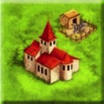

In [19]:
#View tree on each iteration - STEP 2 - Iterate

#By iteration
iterations = 700
def run_iteration(iterations):
    for it in range(iterations):
        mcts_agent.iteration()
run_iteration(iterations)
#cProfile.run("run_iteration(iterations)")

#By_choose_action
def run_choose_action():
    mcts_agent.max_iterations = iterations
    mcts_agent.choose_action(game_state)
#run_choose_action()

print("Iterations: ", mcts_agent.current_iterations)
print("FM calls: ", mcts_agent.current_fm)
print("Recommended action: ", mcts_agent.recommendation_policy())
print(mcts_agent.view_mcts_tree())
#print(mcts_agent.view_action_stats())
#print(mcts_agent.view_proven_tree())
Image("Games/Carcassonne/pygame_images/"+ str(game_state.next_tile_index)+".png")

In [20]:
np.mean(mcts_agent.root_node.leaf_node_depths())

3.6518375241779495

In [ ]:
#Create color palette

color_palette = [ "#B10909" #red
                ,  "#5B8C5A"#green
                ,"#56638A" #blue-purple
                , "#EC7316" #orange
                ,  "#FC738C" ] #pink
color_palette = ["#5B8C5A"
                ,"#56638A"
                , "#EC7316"]
color_palette[2] = eu.color_rgb_to_hex(eu.darken_color(eu.color_hex_to_rgb(color_palette[2]), 0.4))
color_palette[0] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[0]), 0.3))
color_palette[1] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[1]), 0.1))

eu.view_color_palette(color_palette)

print("color_palette = {}".format(color_palette))

In [ ]:
#MATCH

mcts_agent = mcts.MCTS_Player(max_iterations = 100)
siea_mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = 100)
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
game_state = carc.CarcassonneState()
#game_state = mnk.GameState(3,3,3)
game_state.set_initial_state()
gp1, gp2 = eu.play_match([mcts_agent, siea_mcts_agent], game_state, 2, os.path.join("Outputs", "test_match_carc"), random_seed = 1)

In [5]:
#Match with debugger.py

TotalGames = 10
logs = True
random_seed = 1
if random_seed is not None: 
    rd.seed(random_seed)
    np.random.seed(random_seed)
else: 
    random_seed = rd.randint(0, 2**32)
    print("meh")
    rd.seed(random_seed)
    np.random.seed(random_seed)

game_state = carc.CarcassonneState(initial_tile_quantities=[1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = mnk.GameState(m=3,n=3,k=3)
game_state.set_initial_state()
agent3 = arand.RandomPlayer()
agent2 = mcts.MCTS_Player(max_iterations=100)
players = [agent2, agent3]
games_count = 0
WinnerCount = {0:0, 1:0, "Draw":0}

all_action_logs = pd.DataFrame()
all_game_logs = pd.DataFrame()

ST = time.time()

for game in range(TotalGames):
    #gs = game_state.duplicate()
    gs = game_state.duplicate()

    #Set logs
    action_logs = pd.DataFrame()
    game_logs = pd.DataFrame()
    if logs:
        for p in players:
            p.logs = True

    #Play game
    safe_count = 0
    while not gs.is_terminal:
        start_time = time.time()
        action = players[gs.player_turn].choose_action(gs)
        #action = rd.choice(gs.available_actions)
        selection_time = time.time() - start_time

        #Update logs
        if logs:
            action_log = players[gs.player_turn].choose_action_logs #Assumes this log is single row
            action_log["game_index"] = games_count
            action_log["selection_time"] = selection_time
            action_log["returned_action"] = str(action)
            action_log["pg_player"] = str(players[gs.player_turn])
            action_logs = pd.concat([action_logs, action_log], ignore_index=True)
            game_logs = pd.concat([game_logs, gs.logs_data()], ignore_index=True)

        #safety check      
        safe_count += 1
        if safe_count > 1000: 
            print("Safe count exceeded")
            print(gs.logs_data())
            print("Last action:" + str(action))
            break
        assert safe_count < 1000, "Safe count exceeded"

        #Make action
        gs.make_action(action)

    if logs:
        #Final logs by action
        final_logs_by_action = pd.concat([action_logs, game_logs], axis=1)


        #Final logs by game
        final_logs_by_game_dict = {}
        for i, player in enumerate(players):
            final_logs_by_game_dict["Player_" + str(i)] = str(player)
        final_logs_by_game_dict["game_random_seed"] = random_seed
        final_logs_by_game_dict["game_index"] = games_count
        final_logs_by_game = pd.DataFrame(final_logs_by_game_dict, index=[0])
        final_logs_by_game = pd.concat([final_logs_by_game, gs.logs_data()], axis=1)
            
    games_count += 1
    if gs.winner is None:
        WinnerCount["Draw"] += 1
    else: WinnerCount[gs.winner] += 1
    print("Game", games_count, "ended, winner:", gs.winner, "scores:", gs.Scores)

    all_action_logs = pd.concat([all_action_logs, final_logs_by_action], ignore_index=True)
    all_game_logs = pd.concat([all_game_logs, final_logs_by_game], ignore_index=True)

ET = time.time()

all_action_logs.to_csv(os.path.join("Outputs","test_carc","by_action.csv"))
all_game_logs.to_csv(os.path.join("Outputs","test_carc","by_game.csv"))
print("Games ended, time:", str(ET - ST))
print("WinnerCount",WinnerCount)

In [2]:
#Evolved formulas analysis, now in experiment

logs_path = os.path.join("Outputs","FO_single_decision_new")
data = pd.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
evolved_formula_data = pd.DataFrame()
for agent in data["Player"].unique():
    if "EA" in agent:
        for f_index in data["Function_index"].unique():
            tdata = data[(data["Player"]==agent) & (data["Function_index"]==f_index)]
            fa_data = eu.evolved_formula_analysis(tdata)
            fa_data["Player"] = [agent]
            fa_data["Function_index"] = [f_index]
            evolved_formula_data = pd.concat([evolved_formula_data, fa_data])
evolved_formula_data.to_csv(os.path.join(logs_path, "evolved_formula_analysis.csv"), mode='a')

In [ ]:
dupe_state = game_state.duplicate()
dupe_state.make_action(rd.choice(dupe_state.available_actions))

In [8]:
for file_name in ["evolution_logs.csv"]:
    experiment_path = os.path.join("Outputs","FO_single_decision_new2")
    file_path_list = lm.find_log_files(file_name, experiment_path)
    lm.combine_logs(experiment_path, file_name, file_path_list)

In [ ]:
#Plot histograms

n_bins = 2**7
experiment_path = os.path.join("Outputs","FO_single_decision_new2")
file_path_list = lm.find_log_files("tree_data.csv", experiment_path)
print(["\n" + f for f in file_path_list])
for function_index in range(5):
  data_list = []
  subplot_titles = []
  file_paths = []

  #Add ea vanilla
  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
      agent_name = file_path.split(os.sep)[-2]
      if "_c" in agent_name:
        data_list.append(pd.read_csv(file_path)) #mod to get interesting runs
        if "1_4142" in agent_name:
           agent_name= agent_name.replace("1_4142", "\u221A\u03052\u0305")
        if "0_5" in agent_name:
           agent_name= agent_name.replace("0_5", "0.5")
        agent_name = agent_name.replace("MCTS_", "MCTS ")
        agent_name = agent_name.replace(" c", " c = ")
        subplot_titles += [agent_name]
        file_paths += [file_path]
        paths_to_remove += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "EA_" in agent_name and not "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))  #mod to get interesting runs
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
    
  if subplot_titles != [] and data_list != []:
    fop = fo.GameState(function_index=function_index)

    #print(len(data_list))
    """ #mod to get interesting runs
    interesting_runs = [0,10,16,36,41,45,72,73,97]
    interesting_data = []
    interesting_titles = ["Tunnel","Even","Random", "Exploratory", "Opposite", "Emergent 1", "Emergent 2", "Emergent 3", "UCB1 c=0.25"]
    interesting_titles = ["Behaviour type " + str(i) for i in range(len(interesting_runs))]
    for j in range(10):
      new_data_list = []
      subplot_titles = []
      dat = data_list[1]
      for i in range(j*10,(j+1)*10):
        tdat = dat.loc[dat["run"] == i]
        new_data_list = new_data_list + [tdat]
        if i==40:
          my_dat = tdat
        if i in interesting_runs:
          interesting_data += [tdat]
        subplot_titles += ["Run " + str(i)]
      subdata_list = new_data_list
    """

    plot = eu.fo_tree_histogram_average(data_list,  #mod to get interesting runs
                        fop.function, 
                        "F"+str(function_index+1) , #mod to get interesting runs
                        divisions = 3,
                        n_buckets = n_bins, 
                        subplot_titles = [""] + subplot_titles, #mod to get interesting runs
                        max_x_location=fop.max_location[0],
                        y_ref_value=None)
    #plot.write_image(os.path.join(experiment_path, "Interesting_runs.png"))#"F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'))#, width=800, height=1000) 
    plot.write_image(os.path.join(experiment_path, "F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'), width=800, height=1000) 
    plot.show()
    #0,5,

In [1]:
#LUDO

class LudoArrow():
    def __init__(self,  end_index=None, player_house=None):
        self.player_house = player_house #The player whose house this is
        self.end_index = end_index

class LudoSquare():
    def __init__(self, index, is_safe=False, arrow=None, content=None, next_square_index=None, player_house=None, is_victory_path=False):
        self.index = index
        self.is_safe = is_safe
        self.content = content #A list of pieces
        self.next_square_index = next_square_index #The index of the next square
        self.player_house = player_house #The player whose house this sends to
        self.is_victory_path = is_victory_path #Whether this is a victory path square

class LudoPiece():
    def __init__(self, index, player):
        self.index = index
        self.player = player
        
class GameState():
    def __init__(self, n_players, pieces_per_player=4):
        self.players = ["red", "green", "blue", "yellow"]
        self.n_players = n_players
        self.pieces_per_player = pieces_per_player
    def set_initial_state(self):
        self.board = {}
        self.players_houses = {12:"red", 25:"green", 38:"blue", 51:"yellow"}
        self.players_starting_index = {"red":15, "green":28, "blue":41, "yellow":2}
        for i in range(52):
            if i in [2, 10, 15, 23, 28, 36, 41, 49]: #safe squares
                square = LudoSquare(i, is_safe=True)
            elif i in [6, 19, 32, 45]: #squares with immediate arrows
                arrow = LudoArrow(end_index=i+1)
                square = LudoSquare(i, arrow=arrow)
            elif i in [10, 23, 36, 49]: #squares with arrows to the player houses
                arrow = LudoArrow(end_index=53, player_house=i)
                square = LudoSquare(i, arrow=arrow)
            elif i in [13, 26, 39, 52]:
                square = LudoSquare(i, player_house=self.players_houses[i])







In [ ]:
#LORCANA API
import requests
import json
import pandas as pd

names_request = requests.get('https://api.lorcana-api.com/lists/names')
if names_request.status_code == 200:
    response_string = str(names_request.content).split("\\n")
print("Got ", str(len(response_string)), " names from the API")

names = []
card_dataset = []
failed_cards = []
for raw_name in response_string:
    card_data = None
    attempts = 0
    while attempts < 5:
        if "," in raw_name: #Filtering for missing cards
            name = raw_name.replace("\"", "")
            name = name.replace("\\", "")
            name = name.replace(" ", "")
            name = name.replace(",", "")

            full_string = 'https://api.lorcana-api.com/strict/' + name
            print("Trying string: ", full_string)
            #print(full_string)
            card_data = requests.get(full_string)
            if card_data.status_code == 200:
                print(card_data.content)
                break
            else:
                print('Request failed with status code:', card_data.status_code)
                card_data = None
                attempts += 1
        else:
            print("Skipping: ", raw_name)
            break
        
    #Save the data in a dictionary
    if card_data is not None:
        card_dict = json.loads(card_data.content)
        card_dataset.append(card_dict)
    else:
        failed_cards.append(raw_name)
        print("Failed to get data for: ", raw_name)
    
#Merge all the dicionaries in a single dataframe
df = pd.DataFrame()
for card_dict in card_dataset:
    #card_df = pd.DataFrame(card_dict, index = [0])
    card_df = pd.DataFrame()
    for key,value in card_dict.items():
        print(key, value)
        card_df[key] = [value]
    df = pd.concat([df, card_df], axis = 0)
    #Save df to csv
    df.to_csv("card_data.csv", index = False)